<a href="https://colab.research.google.com/github/Ayesha-Imr/Gen-AI-Projects/blob/main/Multimodal_RAG_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install --quiet llama-index-vector-stores-qdrant

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.1/230.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.4/327.4 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: proto

In [ ]:
%pip install --quiet llama_index ftfy regex tqdm
%pip install --quiet git+https://github.com/openai/CLIP.git
%pip install --quiet torch torchvision
%pip install --quiet matplotlib scikit-image
%pip install --upgrade --quiet qdrant_client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 711.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 49.8 MB/s eta 0:00:00


In [ ]:
%pip install --quiet PyMuPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 36.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/RSA RAG Docs
%ls

/content/gdrive/My Drive/RSA RAG Docs
rsa-doc.gdoc  rsa-doc.pdf


In [ ]:
# Open the PDF file
pdf_file = open('rsa-doc.pdf', 'r')

In [ ]:
import fitz  # PyMuPDF
from pathlib import Path

pdf_path = 'rsa-doc.pdf'
data_path = Path("data_pdf")

if not data_path.exists():
    Path.mkdir(data_path)

# Extract text and images
doc = fitz.open(pdf_path)

# Extract text
text_file = data_path / "document_text.txt"
with open(text_file, 'w') as tf:
    for page in doc:
        text = page.get_text()
        tf.write(text)

# Extract images
image_metadata_dict = {}
image_uuid = 0
for page_num in range(len(doc)):
    for img in doc.get_page_images(page_num):
        xref = img[0]
        base_image = doc.extract_image(xref)
        image_bytes = base_image["image"]
        image_ext = base_image["ext"]
        image_filename = data_path / f"image_{image_uuid}.{image_ext}"
        with open(image_filename, "wb") as img_file:
            img_file.write(image_bytes)
        image_metadata_dict[image_uuid] = {
            "filename": f"image_{image_uuid}.{image_ext}",
            "img_path": str(image_filename),
        }
        image_uuid += 1


In [ ]:
import clip
import torch
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Preprocess text
with open(text_file, 'r') as tf:
    text_data = tf.read().splitlines()

# Preprocess images
image_files = [image_metadata_dict[uuid]['img_path'] for uuid in image_metadata_dict]
processed_images = [preprocess(Image.open(img_path)).unsqueeze(0).to(device) for img_path in image_files]


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 162MiB/s]


In [ ]:
# Tokenize and encode text
text_tokens = clip.tokenize(text_data).to(device)
with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens)

# Encode images
with torch.no_grad():
    image_embeddings = torch.cat([model.encode_image(img) for img in processed_images])

# Convert embeddings to numpy for ingestion into Qdrant
text_embeddings_np = text_embeddings.cpu().numpy()
image_embeddings_np = image_embeddings.cpu().numpy()


In [ ]:
import qdrant_client
from qdrant_client.http import models

# Initialize Qdrant client
client = qdrant_client.QdrantClient(path="qdrant_db")

# Define collections for text and image embeddings
client.recreate_collection(
    collection_name="text_collection",
    vectors_config=models.VectorParams(size=text_embeddings_np.shape[1], distance=models.Distance.COSINE)
)

client.recreate_collection(
    collection_name="image_collection",
    vectors_config=models.VectorParams(size=image_embeddings_np.shape[1], distance=models.Distance.COSINE)
)

# Upload text embeddings
client.upsert(
    collection_name="text_collection",
    points=models.Batch(
        ids=list(range(len(text_embeddings_np))),
        vectors=text_embeddings_np,
        payloads=[{"text": text_data[i]} for i in range(len(text_data))]
    )
)

# Upload image embeddings
client.upsert(
    collection_name="image_collection",
    points=models.Batch(
        ids=list(range(len(image_embeddings_np))),
        vectors=image_embeddings_np,
        payloads=[{"image_path": image_files[i]} for i in range(len(image_files))]
    )
)


<ipython-input-10-ef9a9053e5c4>:8: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(
<ipython-input-10-ef9a9053e5c4>:13: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [ ]:
import os

def search_query(query_text, top_k=3):
    # Encode the query text
    query_token = clip.tokenize([query_text]).to(device)
    with torch.no_grad():
        query_embedding = model.encode_text(query_token).cpu().numpy()

    # Search in text collection
    text_results = client.search(
        collection_name="text_collection",
        query_vector=query_embedding[0],
        limit=top_k
    )

    # Search in image collection
    image_results = client.search(
        collection_name="image_collection",
        query_vector=query_embedding[0],
        limit=top_k
    )

    return text_results, image_results



So, What Containers Really Are?
Deploying New Containers
container runtime


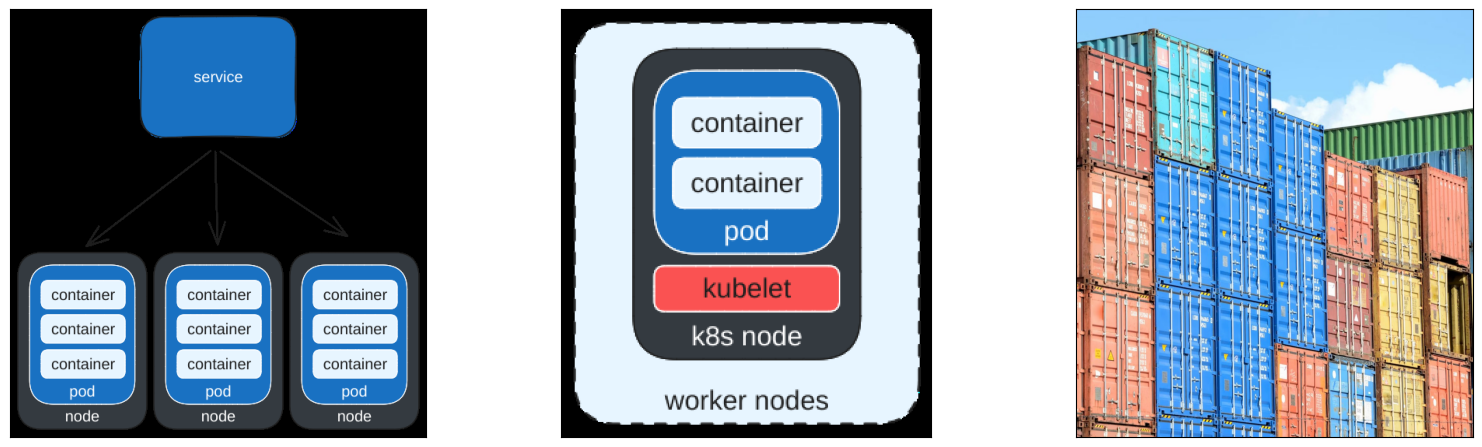

In [ ]:
# Example query
text_query = "What are containers?"
text_results, image_results = search_query(text_query)

# Display results
for result in text_results:
    print(result.payload['text'])

import matplotlib.pyplot as plt

def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)
            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            images_shown += 1
            if images_shown >= 9:
                break
    plt.tight_layout()
    plt.show()

image_paths = [result.payload['image_path'] for result in image_results]
plot_images(image_paths)


What Is Kubernetes Anyways?
Introduction to Kubernetes
Kubernetes Components
Next Time You Deploy Kubernetes – Part 1
Next Time You Deploy Kubernetes – Part 2
Next Time You Deploy Kubernetes – Part 3


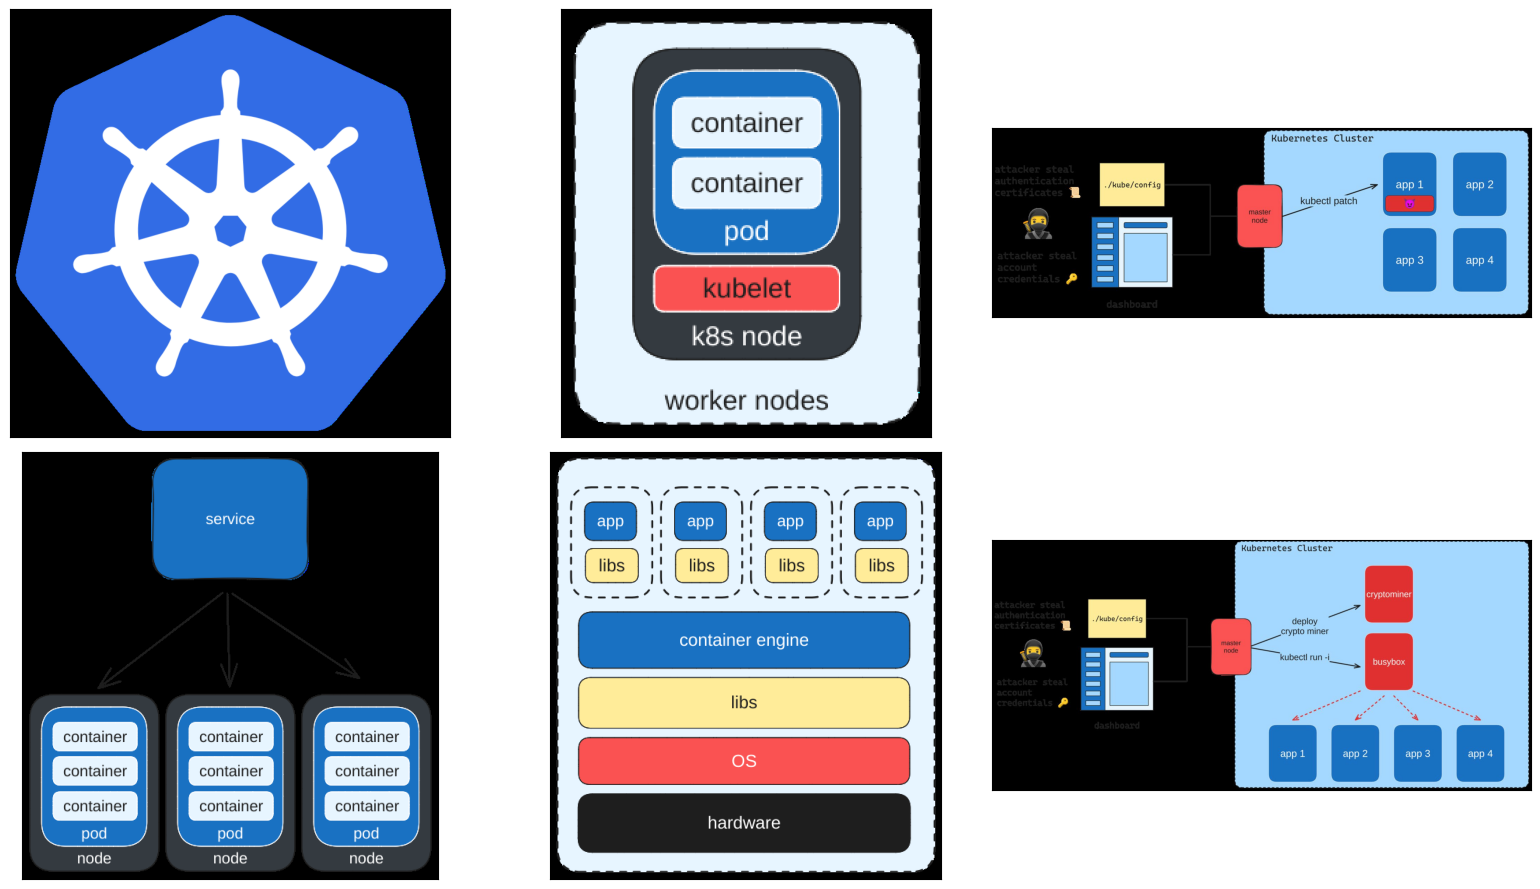

In [ ]:
# Example query
text_query = "What are the components of kubernetes?"
text_results, image_results = search_query(text_query, 6)

# Display results
for result in text_results:
    print(result.payload['text'])

import matplotlib.pyplot as plt

def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)
            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            images_shown += 1
            if images_shown >= 9:
                break
    plt.tight_layout()
    plt.show()

image_paths = [result.payload['image_path'] for result in image_results]
plot_images(image_paths)
